# Continuous Beam PINN - instance prediction

In [1]:
import sys
sys.path.append('..')
import dynasim

import torch
from beam_pinn import normalise, beam_pinn

import numpy as np
from math import pi

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = np.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def plot_vib_surface(ax, x, t_span, w, sub_samp=10):
    if len(x.shape) == 1 and len(t_span.shape) == 1:
        xx, tt = np.meshgrid(x[::sub_samp], t_span[::sub_samp])
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and t_span.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(t_span[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and t_span.shape[1] <= 1:
            xx, tt = np.meshgrid(x[::sub_samp], t_span[::sub_samp])
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

### Set ground truth

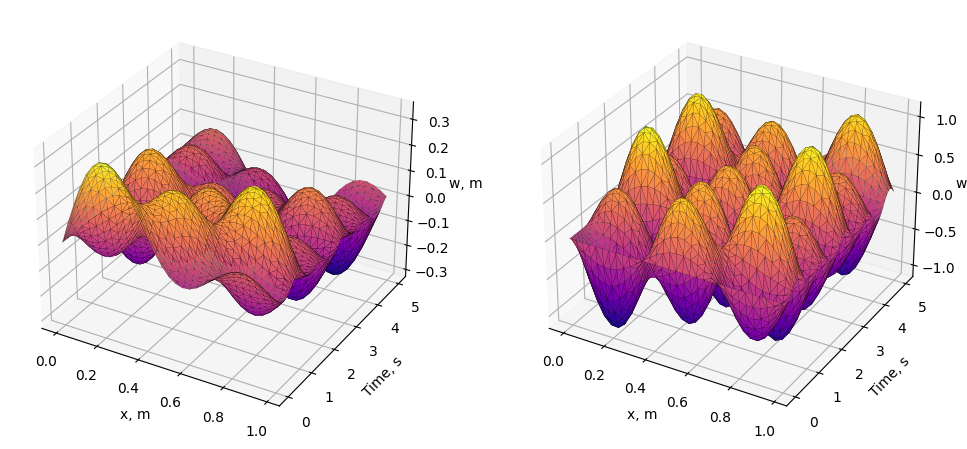

In [3]:
device = torch.device('cpu')

# data parameters
nt = 256
nx = 64
n_modes = 3

# set beam properties
E = 1e7  # Young's modulus
rho = 2700  # density
EI = 5e-3  # flexural rigidity Nm^2
pA = 1.0  # mass per unit length
l = 1.0  # length m
c = 0.05  # damping

# create beam system
beam_kwargs = {
    "EI" : EI,
    "pA" : pA,
    "c" : c,
    "l" : l
}
ss_beam = dynasim.systems.cont_beam("cmb_vars", **beam_kwargs)
xx, phi_n = ss_beam.gen_modes("ss-ss", n_modes, nx)

# set initial/forcing conditions
q0 = 0.1 * np.ones((n_modes))
qd0 = np.zeros((n_modes))
tau0 = np.concatenate((q0, qd0), axis=0)

ss_beam.excitations = [None] * n_modes  # free vibration

# set time vector and simulate
t_span = np.linspace(0, 5, nt)
data = ss_beam.simulate(t_span, z0=tau0)
qq, qqd = data['x'], data['xdot']

# retrieve actual displacements from states
wwn = np.zeros((n_modes, nt, nx))
wwnd = np.zeros((n_modes, nt, nx))

for i in range(n_modes):
    wwn[i,:,:] = qq[i,:].reshape(-1,1) @ phi_n[:,i].reshape(1,-1)
    wwnd[i,:,:] = qqd[i,:].reshape(-1,1) @ phi_n[:,i].reshape(1,-1)
ww = np.sum(wwn, axis=0)
wwd = np.sum(wwnd, axis=0)
    
fig, axs = plt.subplots(1, 2, subplot_kw = {"projection":"3d"}, figsize = (12, 8))
plot_vib_surface(axs[0], xx, t_span, ww, 2)
plot_vib_surface(axs[1], xx, t_span, wwd, 2)

Text(0.5, 1.0, 'Velocity')

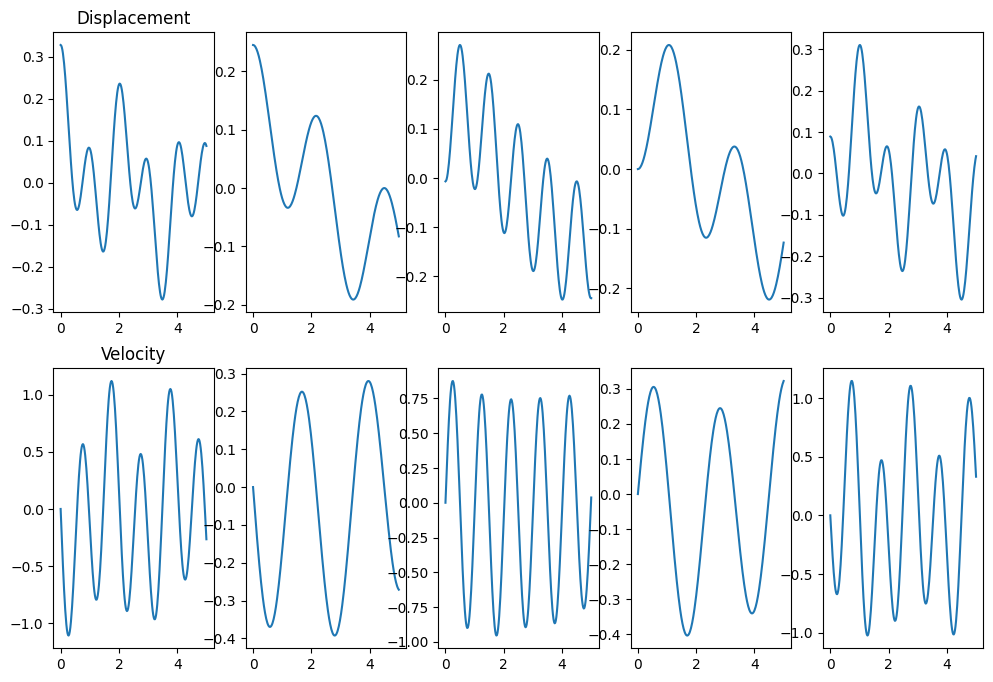

In [4]:
n_sens = 5
sens_distance = xx[-1]/(n_sens+1)  # distance between sensors
s_locs = np.arange(sens_distance, xx[-1], sens_distance)  # target location of sensors
s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(n_sens)]

fig, axs = plt.subplots(2, n_sens, figsize = (12,8))
for i in range(n_sens):
    axs[0,i].plot(t_span, ww[:,s_ids[i]])
    axs[1,i].plot(t_span, wwd[:,s_ids[i]])
axs[0,0].set_title('Displacement')
axs[1,0].set_title('Velocity')

Normalise, subsample, convert to tensors, and replot

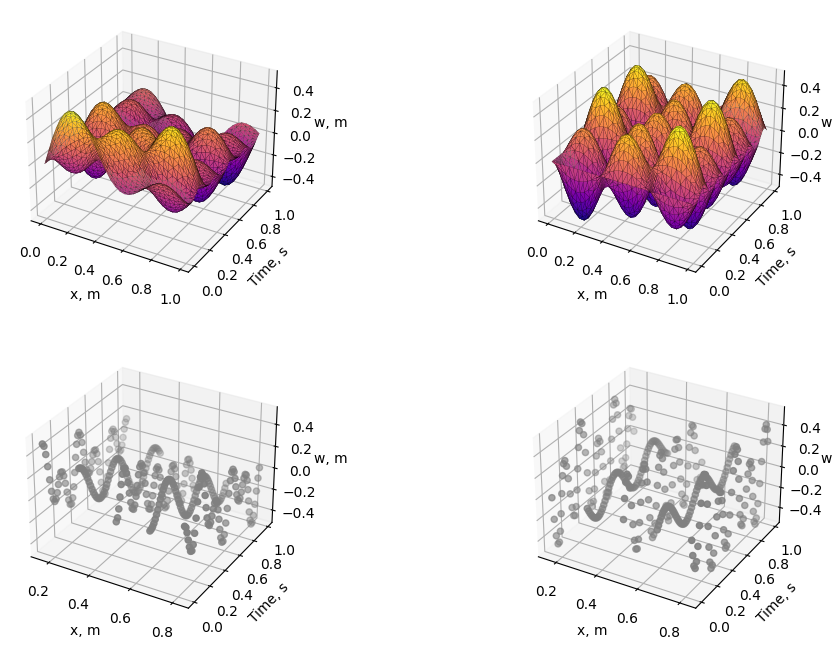

In [5]:
t_hat, alpha_t = normalise(t_span, "range")
x_hat, alpha_x = normalise(xx, "range")
w_hat_gt, alpha_w = normalise(ww, "range", "all")
wd_hat_gt, alpha_wd = normalise(wwd, "range", "all")
q_hat_gt, alpha_q = normalise(qq.T, "range", "all")
qd_hat_gt, alpha_qd = normalise(qqd.T, "range", "all")

# observation data
sub_ind_t = np.arange(0, int(nt/1), 4)
# sub_ind_x = np.arange(0, int(nx/1), 16)
sub_ind_x = s_ids
t_data = torch.tensor(t_hat[sub_ind_t], dtype=torch.float32).to(device)
x_data = torch.tensor(x_hat[sub_ind_x], dtype=torch.float32).to(device)
w_data = torch.tensor(w_hat_gt[sub_ind_t,:][:,sub_ind_x], dtype=torch.float32).to(device)
wd_data = torch.tensor(wd_hat_gt[sub_ind_t,:][:,sub_ind_x], dtype=torch.float32).to(device)
q_data = torch.tensor(q_hat_gt[sub_ind_t], dtype=torch.float32).to(device)
qd_data = torch.tensor(qd_hat_gt[sub_ind_t], dtype=torch.float32).to(device)

# collocation data
t_coll = torch.tensor(t_hat, dtype=torch.float32).to(device)
x_coll = torch.tensor(x_hat, dtype=torch.float32).to(device)

fig, axs = plt.subplots(2, 2, subplot_kw = {"projection":"3d"}, figsize = (12, 8))
plot_vib_surface(axs[0,0], x_hat, t_hat, w_hat_gt, 2)
plot_vib_surface(axs[0,1], x_hat, t_hat, wd_hat_gt, 2)
plot_vib_scatter(axs[1,0], np.tile(x_data.reshape(1,-1), (t_data.shape[0], 1)), np.tile(t_data.reshape(-1,1), (1, x_data.shape[0])), w_data)
plot_vib_scatter(axs[1,1], np.tile(x_data.reshape(1,-1), (t_data.shape[0], 1)), np.tile(t_data.reshape(-1,1), (1, x_data.shape[0])), wd_data)

In [6]:
ground_truth = {
    "t_hat" : torch.tensor(t_hat, dtype=torch.float32),
    "x_hat" : torch.tensor(x_hat, dtype=torch.float32),
    "w_hat" : torch.tensor(w_hat_gt, dtype=torch.float32),
    "wd_hat" : torch.tensor(wd_hat_gt, dtype=torch.float32),
    "q_hat" : torch.tensor(q_hat_gt, dtype=torch.float32),
    "qd_hat" : torch.tensor(qd_hat_gt, dtype=torch.float32)
}

obs_data = {
    "t_hat" : t_data.reshape(-1,1),
    "x_hat" : x_data,
    "w_hat" : w_data,
    "wd_hat" : wd_data,
    "sub_ind_t" : torch.tensor(sub_ind_t, dtype=torch.int).to(device),
    "sub_ind_x" : torch.tensor(sub_ind_x, dtype=torch.int).to(device)
}

coll_data = {
    "t_hat" : t_coll.reshape(-1,1),
    "x_hat" : x_coll
}

prediction = {
    "t_hat" : torch.tensor(t_hat, dtype=torch.float32).to(device),
    "x_hat" : torch.tensor(x_hat, dtype=torch.float32),
    "w_hat" : None,
    "wd_hat" : None,
    "q_hat" : None,
    "qd_hat": None
}

alphas = {
    "t" : torch.tensor(alpha_t, dtype=torch.float32),
    "x" : torch.tensor(alpha_x, dtype=torch.float32),
    "w" : torch.tensor(alpha_w, dtype=torch.float32),
    "wd" : torch.tensor(alpha_wd, dtype=torch.float32),
    "q" : torch.tensor(alpha_q, dtype=torch.float32),
    "qd" : torch.tensor(alpha_qd, dtype=torch.float32)
}

In [7]:
def plot_nn_update(axs_m, ground_truth, data, prediction, alphas, plot_ids):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(prediction["t_hat"])*alphas["t"]
    for i in range(2):
        axs[i].plot(ground_truth["t_hat"]*alphas["t"], ground_truth["w_hat"][:,plot_ids[i]]*alphas["w"], color="grey", linewidth=1.5, alpha=0.8, label="Ground Truth")
        axs[i].plot(prediction["t_hat"]*alphas["t"], prediction["w_hat"][:,plot_ids[i]]*alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(data["t_hat"]*alphas["t"], data["w_hat"][:,i]*alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(ground_truth["w_hat"][:,plot_ids[i]]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
        axs[i].legend()

    axs[2].plot(ground_truth["t_hat"]*alphas["t"], ground_truth["wd_hat"][:,plot_ids[i]]*alphas["wd"], color="grey", linewidth=1.5, alpha=0.8, label="Ground Truth")
    axs[2].plot(prediction["t_hat"]*alphas["t"], prediction["wd_hat"][:,plot_ids[i]]*alphas["wd"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
    axs[2].scatter(data["t_hat"]*alphas["t"], data["wd_hat"][:,i]*alphas["wd"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    yL = torch.amax(torch.abs(ground_truth["wd_hat"][s_ids[i],:]))*alphas["wd"]
    axs[2].set_xlim(-0.05*xL, 1.05*xL)
    axs[2].set_ylim(-1.1*yL, 1.1*yL)
    axs[2].legend()
    
    # axs[2].plot(prediction["x_hat"]*alphas["x"], prediction["w_hat"][0,:]*alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
    # axs[2].plot(ground_truth["x_hat"]*alphas["x"], ground_truth["w_hat"][0,:]*alphas["w"], color="tab:red")
    # axs[2].scatter(data["x_hat"]*alphas["x"], data["w_hat"][0,:]*alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    # yL = torch.amax(torch.abs(ground_truth["w_hat"][:,s_ids[i]]))*alphas["w"]
    # axs[2].set_xlim(-0.05, 1.05)
    # axs[2].set_ylim(-1.1*yL, 1.1*yL)
    # axs[2].legend()

    axs_m['E'].cla()
    plot_vib_surface(axs_m['E'], prediction["x_hat"]*alphas["x"], prediction["t_hat"]*alphas["t"], prediction["w_hat"]*alphas["w"], 2)

def plot_loss_hist(ax, loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    loss_labs = ['Observation loss', 'Physics loss', 'CC loss', 'Total loss']
    loss_cols = ['b', 'r', 'g', 'k']
    for i in range(loss_hist.shape[1]):
        ax.plot(np.arange(1,n_epoch+1), loss_hist[:,i], loss_cols[i], label=loss_labs[i])
    ax.set_yscale('log')
    ax.legend()

100%|██████████| 50000/50000 [01:06<00:00, 1267.74it/s]

Epoch: 49999	--------	Loss: 0.000039



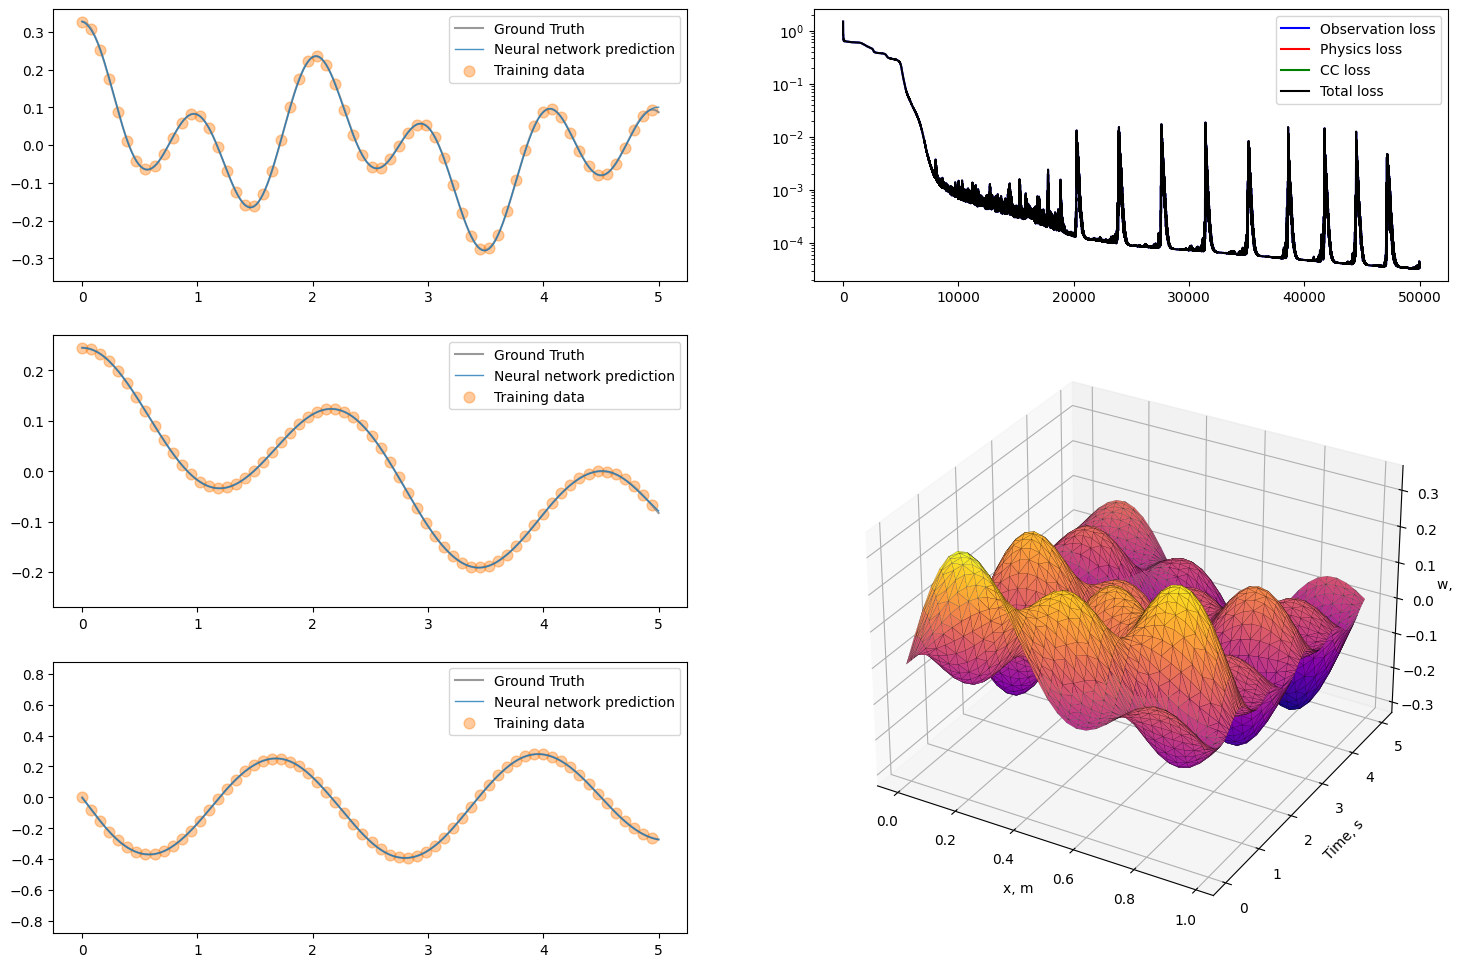

100%|██████████| 50000/50000 [01:20<00:00, 1267.74it/s]

In [10]:
pinn_config = {
    "n_hidden" : 32,
    "n_layers" : 4,
    "n_modes" : n_modes,
    "modes" : {
        "phi" : torch.tensor(phi_n, dtype=torch.float32),
        "sens_ids" : s_ids,
    },
    "phys_params" : {
        "M" : {
            "type" : "constant",
            "value" : torch.tensor(ss_beam.M, dtype=torch.float32)
        },
        "C" : {
            "type" : "constant",
            "value" : torch.tensor(ss_beam.C, dtype=torch.float32)
        },
        "K" : {
            "type" : "constant",
            "value" : torch.tensor(ss_beam.K, dtype=torch.float32)
        }
    },
    "alphas" : alphas,
}

# configure pinn
beam_pinn_model = beam_pinn(pinn_config)
beam_pinn_model.set_colls_and_obs(obs_data, coll_data)

# configure optimiser
learning_rate = 1e-3
betas = (0.99, 0.999)
optimizer = torch.optim.Adam(beam_pinn_model.parameters(), lr=learning_rate, betas=betas)

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )
dh = display.display(fig, display_id=True)
print_step = 2000
loss_hist = []
lambds = {
    'obs' : 1.0,
    'ode' : 0.0,
    'cc' : 0.0
}

beam_pinn_model.set_switches(lambds)
beam_pinn_model.to(device)

num_epochs = int(50e3)
epoch = 0

if 'progress_bar' in locals():
    progress_bar.clear()
progress_bar = tqdm(total=num_epochs)

while epoch < num_epochs:
    write_string = ''
    write_string += 'Epoch: {}\t--------\t'.format(epoch)

    optimizer.zero_grad()

    loss, losses, residuals = beam_pinn_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()
    write_string += 'Loss: {:6f}\n'.format(loss)

    if (epoch+1) % print_step == 0:
        z_pred = beam_pinn_model.predict_w(t_coll.unsqueeze(1)).detach()

        prediction["w_hat"] = z_pred[0,...].squeeze()
        prediction["wd_hat"] = z_pred[1,...].squeeze()

        plot_nn_update(axs, ground_truth, obs_data, prediction, alphas, s_ids)

        plot_loss_hist(axs['D'], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(fig, progress_bar)
        tqdma.write(write_string)

    epoch += 1
    progress_bar.update(1)
    
display.clear_output()
tqdma.write(write_string)